# ***Assignment 1: Traffic Signal Classification***

## **Importing Libraries**

In [43]:
#Importing Libraries
import os
import cv2
import time
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from sklearn.svm import SVC
from cv2 import HOGDescriptor
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, cross_validate, cross_val_score, StratifiedShuffleSplit
import warnings
warnings.filterwarnings("ignore")

## **Data Preprocessing**

In [44]:
arr = os.listdir("/content/drive/MyDrive/CV/CS67_Fall2022_ A1_Dataset") # Getting the folders in the given dataset
if ".DS_Store" in arr: # Deleting the unwanted .DS_Sore file
   arr.remove(".DS_Store")
arr = sorted(arr, key=int) # Sort the folders base on the naming convention
data = ["train", "test"] # txt Files in Dataset folders
df_list = [] # List that will contain the dataframe dict
for x in data: # Creating the dictionaries of test and train data
    for y in arr:
        with open(f"/content/drive/MyDrive/CV/CS67_Fall2022_ A1_Dataset/{y}/{x}.txt") as f:
            for line in f:
                df_dict = {}
                df_dict["data_folder"] = y
                df_dict["data_filename"] = line
                df_dict["data_filetype"] = x    
                df_dict["data_filepath"] = f"/content/drive/MyDrive/CV/CS67_Fall2022_ A1_Dataset/{y}/{line}".strip()
                df_dict["data_label"] = int(y)  
                df_list.append(df_dict)
df = pd.DataFrame.from_dict(df_list) # creating the dataframe from the dictionaries
df.head(5) # printing the first 5 samples

,data_folder,data_filename,data_filetype,data_filepath,data_label
0,00001,00468_00002.ppm\n,train,/content/drive/MyDrive/CV/CS67_Fall2022_ A1_Da...,1
1,00001,00475_00000.ppm\n,train,/content/drive/MyDrive/CV/CS67_Fall2022_ A1_Da...,1
2,00001,00475_00001.ppm\n,train,/content/drive/MyDrive/CV/CS67_Fall2022_ A1_Da...,1
3,00001,00475_00002.ppm\n,train,/content/drive/MyDrive/CV/CS67_Fall2022_ A1_Da...,1
4,00001,00801_00000.ppm\n,train,/content/drive/MyDrive/CV/CS67_Fall2022_ A1_Da...,1


In [45]:
X_train = [] # Initialize lists to store train images
y_train = []
X_test = [] # Initialize lists to store test images
y_test = []
for _, row in tqdm(df.iterrows(), 
              total=df.shape[0]): # iterate the entire dataframe and seperate the train and test files
    if row.data_filetype == "train":
        img = cv2.imread(row.data_filepath) # Read the file using filepath given in dataframe.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert to grayscale
        img = cv2.resize(img, (128, 128))
        X_train.append(img) # Append the loaded image in training data list 
        y_train.append(row.data_label)
    else:
        img = cv2.imread(row.data_filepath) # Read the file using filepath given in dataframe.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert to grayscale
        img = cv2.resize(img, (128, 128))
        X_test.append(img) # Append the loaded image in test data list
        y_test.append(row.data_label)

# Convert train and test data to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

print("Training Set Shape: ", X_train.shape)
print("Test Set Shape: ", X_test.shape)

100%|██████████| 1000/1000 [00:04<00:00, 231.24it/s]

Training Set Shape:  (800, 128, 128)
Test Set Shape:  (200, 128, 128)


###**Data Visualization**

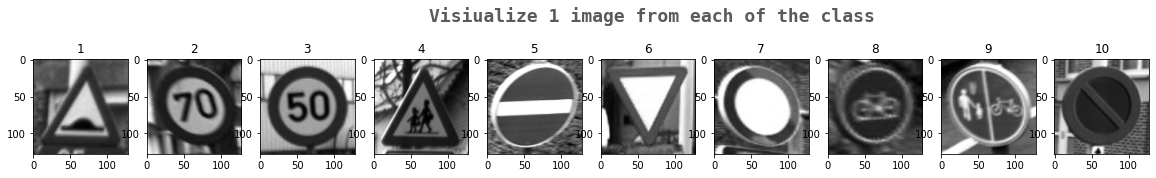

In [46]:
z=0 
fig, ax = plt.subplots(1,10,figsize=(20,10))    # Visuilizing 1 image from each class
fig.text(s='Visiualize 1 image from each of the class',size=18,fontweight='bold',
             fontname='monospace',color='#313131',y=0.62,x=0.4,alpha=0.8) # setting the parameters
for x in df["data_label"].unique():  # unique labels are used to visiualize images
    y=0
    while True : 
        if y_train[y]==x:
            ax[z].imshow(X_train[y], 'gray')
            ax[z].set_title(y_train[y])
            ax[z].axis('on')
            z+=1
            break
        y+=1

## **Supervised Classification**
Supervised classification is the technique most often used for the quantitative analysis of remote sensing image data. At its core is the concept of segmenting the spectral domain into regions that can be associated with the ground cover classes of interest to a particular application.

### **HOG Descriptor**
HOG, or Histogram of Oriented Gradients, is a feature descriptor that is often used to extract features from image data. It is widely used in computer vision tasks for object detection.

In [47]:
window_Size = (128,128) # setting the window size 
block_Size = (32,32) # setting the block size
block_Stride = (16,16) # setting the block stride
cell_Size = (32,32) # setting the cell size
no_bins = 9 # setting the number of bins
deriv_Aperture = 1
Sigma = -1. # setting the value of sigma
histogramNormType = 0
L2HysThreshold = 0.2
gamma = 1 # setting the value of gamma
no_levels = 64
signed_Gradients = True
# running Hog descriptor
hog = cv2.HOGDescriptor(window_Size,block_Size,block_Stride,cell_Size,no_bins,deriv_Aperture,Sigma,histogramNormType,L2HysThreshold,gamma,no_levels, signed_Gradients)
# Initialize lists that will store train and test 
train_hog = [] # Initialize lists to store train hog descriptors
test_hog = [] # Initialize lists to store test hog descriptors
for x in data: # This for loop will handle iterate over "train" amd "test" and will handle X_train and X_test 
    if x=="train":
        for img in X_train:
            desc = hog.compute(img)   # Hog descriptor for training images
            train_hog.append(desc)
    else:
        for img in X_test:
            desc = hog.compute(img)   # Hog descriptor for test images
            test_hog.append(desc)

### **SVM Classifier**
Support Vectors are simply the coordinates of individual observation. The SVM classifier is a frontier that best segregates the two classes (hyper-plane/ line).

In [48]:
# Using SVM classifier for Quatitative and qualitative analysis
def SVM(X,Y,x,y):
  grid = {'C': [0.1, 1, 10, 100],'kernel': ['poly', 'rbf', 'sigmoid']} # Define parameter grid for Grid Search  
  svm=SVC(random_state=42)  # SVM model initialization
  svm_cv = GridSearchCV(svm, grid, scoring='accuracy')   
  svm_cv.fit(X,Y)   # fitting the model for grid search
  svm=svm_cv.best_estimator_  # Best model parameters are stored
  print('\n Quantitative Results \n')
  svm_p=svm_cv.best_estimator_.predict(x)

  x_axis = sorted(np.unique(Y)) # labels for x-axis
  y_axis = sorted(np.unique(Y)) # labels for y-axis
  
  sns.heatmap(confusion_matrix(y, svm_p), annot = True, xticklabels=x_axis, yticklabels=y_axis)
  plt.xlabel("Predicted Class")
  plt.ylabel("Actual Class")
  print(classification_report(y, svm_p))

  return svm_p

### **Quantitative Analysis**


 Quantitative Results 

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        20
           8       1.00      1.00      1.00        20
           9       1.00      1.00      1.00        20
          10       1.00      1.00      1.00        20

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



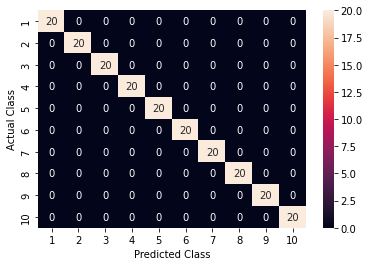

In [49]:
y_pred = SVM(train_hog, y_train, test_hog, y_test) # Quantitative analysis

### **Qualitative Analysis**

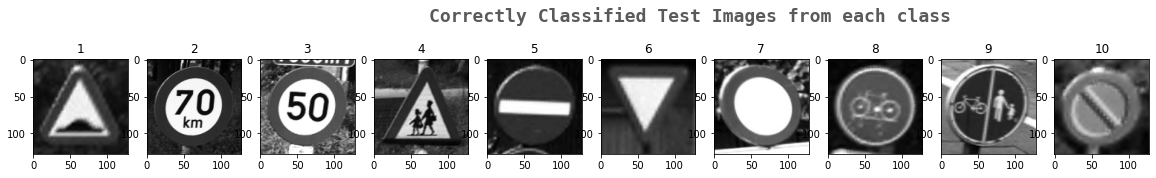

In [50]:
z=0
fig, ax = plt.subplots(1,10,figsize=(20,10))    # Grid of images
fig.text(s='Correctly Classified Test Images from each class',size=18,fontweight='bold',
             fontname='monospace',color='#313131',y=0.62,x=0.4,alpha=0.8)
for x in df["data_label"].unique():  # unique labels are used to visiualize images
    y=0
    while True: 
        if y_test[y]==x and y_pred[y]==x: # Correctly Classified Test Images from each class
            ax[z].imshow(X_test[y], 'gray')
            ax[z].set_title(y_pred[y])
            ax[z].axis('on')
            z+=1
            break
        y+=1

## **Unsupervised Classification**
The goal of unsupervised classification is to automatically segregate pixels of a remote sensing image into groups of similar spectral character. Classification is done using one of several statistical routines generally called “clustering” where classes of pixels are created based on their shared spectral signatures.

### **SIFT Descriptor**
A SIFT descriptor is a 3-D spatial histogram of the image gradients in characterizing the appearance of a keypoint. The gradient at each pixel is regarded as a sample of a three-dimensional elementary feature vector, formed by the pixel location and the gradient orientation.

In [51]:
def getDescriptors(sift, img): # initializing the SIFT descriptor
    kp, desc = sift.detectAndCompute(img, None)
    return desc
def vstackDescriptors(descriptor_list): #initializing sift for list
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 
    return descriptors
def clusterDescriptors(descriptors, no_clusters): # using Kmeans clustring 
    kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    return kmeans
def extractFeatures(kmeans, descriptor_list, image_count, no_clusters): # initializing Kmeans clustring
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 128)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1
    return im_features
def normalizeFeatures(scale, features): # normalizing features
    return scale.transform(features)
def plotHistogram(im_features, no_clusters): # plotting the histogram of kmeans clustering
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])
    plt.figure(figsize=(20,10))
    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index") #labeling the graph
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()
def svcParamSelection(X, y, kernel, nfolds):
    Cs = [0.1, 1, 10, 100]
    gammas = [0.1, 0.11, 0.095, 0.105]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

### **SVM Classifier**
Support Vectors are simply the coordinates of individual observation. The SVM classifier is a frontier that best segregates the two classes (hyper-plane/ line).

In [52]:
def findSVM(im_features, train_labels, kernel): # initializing the SVM classifier
    features = im_features
    if kernel == "precomputed":
      features = np.dot(im_features, im_features.T)  
    params = svcParamSelection(features, train_labels, kernel, 5)
    C_param, gamma_param = params.get("C"), params.get("gamma")
    print(C_param, gamma_param)
    svm = SVC(kernel = kernel, C =  C_param, gamma = gamma_param)
    svm.fit(features, train_labels)
    return svm

In [53]:
def trainModel(trainingData, trainLabels, no_clusters, kernel): # training the sift descriptor using svm classifier
    sift = cv2.SIFT_create()
    descriptor_list = [] 
    train_labels = trainLabels
    label_count = 10
    image_count = X_train.shape[0]
    for img in trainingData:
        des = getDescriptors(sift, img)
        descriptor_list.append(des)
    descriptors = vstackDescriptors(descriptor_list)
    kmeans = clusterDescriptors(descriptors, no_clusters)
    im_features = extractFeatures(kmeans, descriptor_list, image_count, no_clusters)
    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    plotHistogram(im_features, no_clusters)
    print("Features histogram plotted.")
    svm = findSVM(im_features, train_labels, kernel)
    print("Training completed.")
    return kmeans, scale, svm, im_features
    

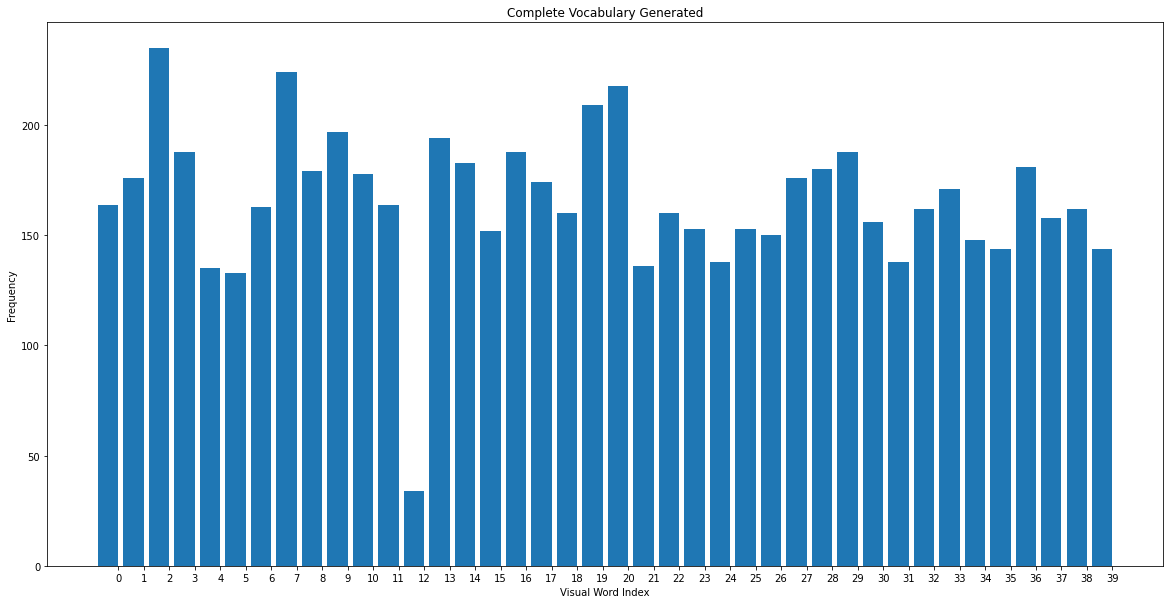

Features histogram plotted.
0.1 0.1
Training completed.


In [54]:
no_clusters = 40
kernel = "precomputed"
kmeans, scale, svm, im_features = trainModel(X_train, y_train, no_clusters, kernel)


In [55]:
def testModel(testData, kmeans, scale, svm, im_features, no_clusters, kernel):
    count = 0
    true = []
    descriptor_list = []
    sift = cv2.SIFT_create()
    for img in testData:
        desc = getDescriptors(sift, img)
        if desc is not None:
            count += 1
            descriptor_list.append(desc)
    descriptors = vstackDescriptors(descriptor_list)
    test_features = extractFeatures(kmeans, descriptor_list, count, no_clusters)
    test_features = scale.transform(test_features)
    kernel_test = test_features
    if kernel == "precomputed":
        kernel_test = np.dot(test_features, im_features.T)
    predictions = svm.predict(kernel_test)
    print("Test images classified.")
    return predictions

In [57]:
y_pred = testModel(X_test, kmeans, scale, svm, im_features, no_clusters, kernel)

Test images classified.


### **Quantitative Analysis**

              precision    recall  f1-score   support

           1       0.65      0.75      0.70        20
           2       0.86      0.90      0.88        20
           3       0.84      0.80      0.82        20
           4       0.86      0.60      0.71        20
           5       0.47      0.40      0.43        20
           6       0.50      0.35      0.41        20
           7       0.41      0.55      0.47        20
           8       0.86      0.90      0.88        20
           9       0.90      0.95      0.93        20
          10       0.43      0.50      0.47        20

    accuracy                           0.67       200
   macro avg       0.68      0.67      0.67       200
weighted avg       0.68      0.67      0.67       200



Text(33.0, 0.5, 'Actual Class')

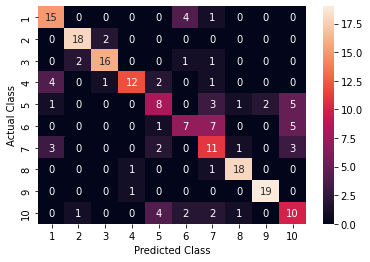

In [58]:
print(classification_report(y_test, y_pred))
x_axis = sorted(np.unique(y_test)) # labels for x-axis
y_axis = sorted(np.unique(y_test)) # labels for y-axis
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, xticklabels=x_axis, yticklabels=y_axis)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

### **Qualitative Analysis**

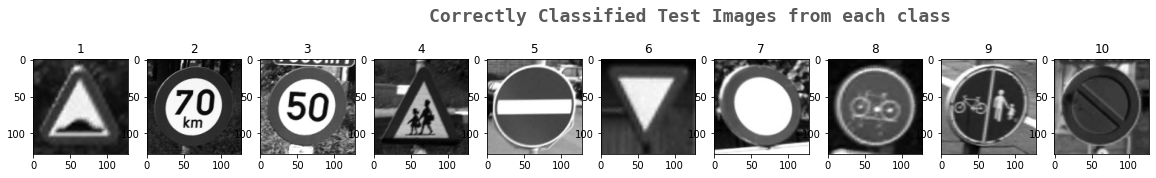

In [59]:
# Correctly Classified Test Images from each class
z=0
fig, ax = plt.subplots(1,10,figsize=(20,10))    # Grid of images
fig.text(s='Correctly Classified Test Images from each class',size=18,fontweight='bold',
             fontname='monospace',color='#313131',y=0.62,x=0.4,alpha=0.8)
for x in df["data_label"].unique():  # unique labels are used to visiualize images
    y=0
    while True:
        if y_test[y]==x and y_pred[y]==x:
            ax[z].imshow(X_test[y], 'gray')
            ax[z].set_title(y_pred[y])
            ax[z].axis('on')
            z+=1
            break
        y+=1